You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# 1. Competition Overview
In this competition you will work with a challenging **time-series** dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

### File descriptions
- **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
- **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission.csv** - a sample submission file in the correct format.
- **items.csv** - supplemental information about the items/products.
- **item_categories.csv**  - supplemental information about the items categories.
- **shops.csv**- supplemental information about the shops.


## 1.1 Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set()

from itertools import product

## 1.2 Load data
Submissions are evaluated by **root mean squared error (RMSE)**. True target values are clipped into [0,20] range.

In [2]:
sales = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv.gz')
submission = pd.read_csv('sample_submission.csv.gz')

Let's check data shapes.

In [4]:
print('Size of sales :', sales.shape)
print('Size of test :', test.shape)
print('Size of shops :', shops.shape)
print('Size of items :', items.shape)
print('Size of item_cats :', item_cats.shape)


Size of sales : (2935849, 6)
Size of test : (214200, 3)
Size of shops : (60, 2)
Size of items : (22170, 3)
Size of item_cats : (84, 2)


# 2. Explorary Data Analysis
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [5]:
print('Train Unique shops :', len(sales['shop_id'].unique()))
print('Test Unique shops :', len(test['shop_id'].unique()))
print('Train Unique items:', len(sales['item_id'].unique()))
print('Test Unique items :', len(test['item_id'].unique()))
print('min item prize :', min(sales['item_price']))
print('max item prize :', max(sales['item_price']))

Train Unique shops : 60
Test Unique shops : 42
Train Unique items: 21807
Test Unique items : 5100
min item prize : -1.0
max item prize : 307980.0


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Add **item_category_id** to **sales** as a feature

In [10]:
sales['item_category_id'] = sales['item_id'].map(sales['item_id'].map(items['item_category_id']))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,43
1,03.01.2013,0,25,2552,899.00,1.0,40
2,05.01.2013,0,25,2552,899.00,-1.0,40
3,06.01.2013,0,25,2554,1709.05,1.0,37
4,15.01.2013,0,25,2555,1099.00,1.0,30


## 2.1 Check for missing data
It seems look pretty good that there is no missing data.

In [12]:
sales.isnull().sum().sort_values(ascending = False)

item_category_id    0
item_cnt_day        0
item_price          0
item_id             0
shop_id             0
date_block_num      0
date                0
dtype: int64

## 2.2 Distribution of item_price

percentage : 0.9884765871814252


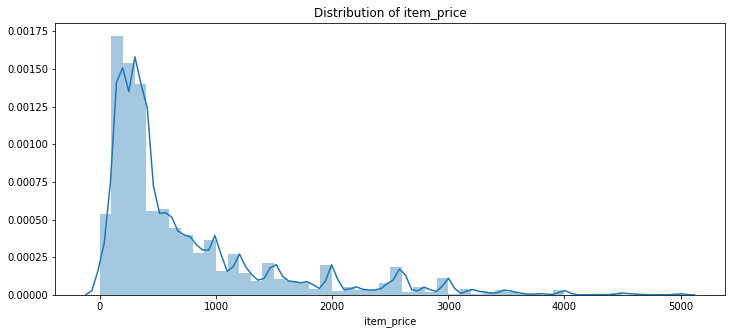

In [13]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_price")
ax = sns.distplot(sales[sales['item_price']<5000]['item_price'])
print('percentage :', len(sales[sales['item_price']<5000])/sales.shape[0])

percentage : 0.9999989781490806


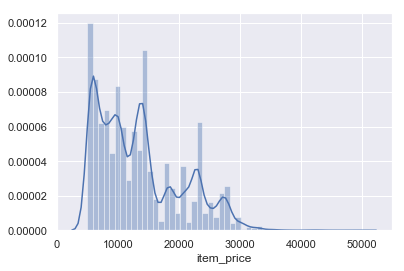

In [71]:
ax = sns.distplot(sales[(sales['item_price']>5000) & (sales['item_price']<50000)]['item_price'])
print('percentage :', len(sales[sales['item_price']<50000])/sales.shape[0])

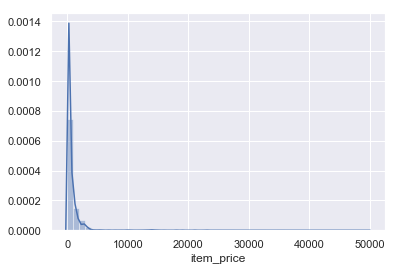

In [72]:
ax = sns.distplot(sales[sales['item_price']<50000]['item_price'])

Check some high item_price ID in both train set and test set.

Check the item_name.

In [16]:
set(sales[sales['item_price']>40000]['item_id']).intersection(set(test['item_id']))

{11365, 13403}

In [17]:
sales[sales['item_price']>40000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
885138,17.09.2013,8,12,11365,59200.0,1.0,75
1006638,24.10.2013,9,12,7238,42000.0,1.0,30
1163158,13.12.2013,11,12,6066,307980.0,1.0,37
1488135,20.03.2014,14,25,13199,50999.0,1.0,37
2143903,20.11.2014,22,12,14173,40900.0,1.0,64
2327159,29.01.2015,24,12,7241,49782.0,1.0,40
2885692,23.10.2015,33,42,13403,42990.0,1.0,30
2893100,20.10.2015,33,38,13403,41990.0,1.0,30
2910155,20.10.2015,33,12,13403,41990.0,1.0,30
2910156,29.10.2015,33,12,13403,42990.0,1.0,30


In [18]:
sales[sales['item_id']==11365]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
58283,09.01.2013,0,12,11365,1148.000000,5.0,75
58284,10.01.2013,0,12,11365,2235.000000,2.0,75
58285,14.01.2013,0,12,11365,1753.333333,3.0,75
58286,15.01.2013,0,12,11365,1435.000000,2.0,75
58287,16.01.2013,0,12,11365,1930.000000,1.0,75
58289,17.01.2013,0,12,11365,1115.000000,6.0,75
58318,21.01.2013,0,12,11365,1600.000000,1.0,75
58319,24.01.2013,0,12,11365,3170.000000,1.0,75
58320,25.01.2013,0,12,11365,1620.000000,1.0,75
58350,28.01.2013,0,12,11365,920.000000,1.0,75


In [19]:
print(items[items['item_id']==13403]['item_name'])
print(items[items['item_id']==11365]['item_name'])

13403    Комплект "Microsoft Xbox One 1TB  Limited Edit...
Name: item_name, dtype: object
11365    Доставка (EMS)
Name: item_name, dtype: object


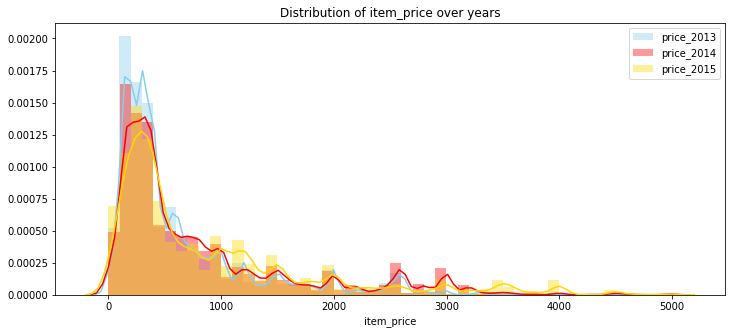

In [20]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_price over years")

price_2013 = sales[(sales['item_price']<5000) & (sales['date_block_num']<13)]['item_price']
price_2014 = sales[(sales['item_price']<5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_price']
price_2015 = sales[(sales['item_price']<5000) & (24<sales['date_block_num'])]['item_price']

sns.distplot( price_2013 , color="skyblue", label="price_2013")
sns.distplot( price_2014 , color="red", label="price_2014")
sns.distplot( price_2015 , color="gold", label="price_2015")
plt.legend()

## 2.3 Distribution of shop_id

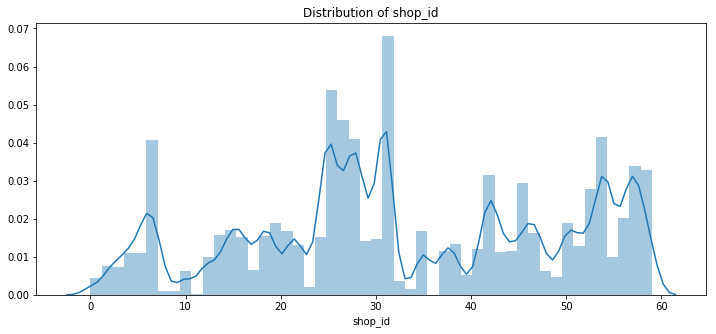

In [21]:
plt.figure(figsize=(12,5))
plt.title("Distribution of shop_id")
ax = sns.distplot(sales['shop_id'])

In [22]:
sales[(sales['date_block_num']<13)].groupby('shop_id').item_cnt_day

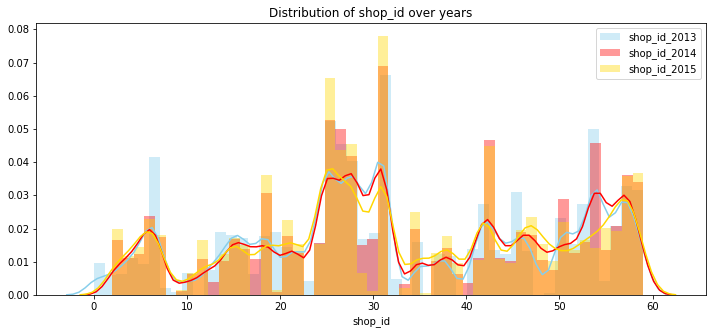

In [23]:
plt.figure(figsize=(12,5))
plt.title("Distribution of shop_id over years")

shop_id_2013 = sales[(sales['date_block_num']<13)]['shop_id']
shop_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['shop_id']
shop_id_2015 = sales[(24<sales['date_block_num'])]['shop_id']

sns.distplot( shop_id_2013 , color="skyblue", label="shop_id_2013")
sns.distplot( shop_id_2014 , color="red", label="shop_id_2014")
sns.distplot( shop_id_2015 , color="gold", label="shop_id_2015")
plt.legend()

## 2.4 Distribution of item_category_id

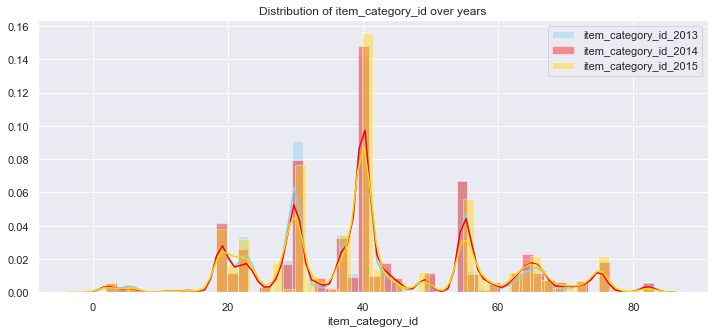

In [69]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_category_id over years")

item_category_id_2013 = sales[(sales['date_block_num']<13)]['item_category_id']
item_category_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_category_id']
item_category_id_2015 = sales[(24<sales['date_block_num'])]['item_category_id']

sns.distplot( item_category_id_2013 , color="skyblue", label="item_category_id_2013")
sns.distplot( item_category_id_2014 , color="red", label="item_category_id_2014")
sns.distplot( item_category_id_2015 , color="gold", label="item_category_id_2015")
plt.legend()

## 2.5 Distribution of item_id

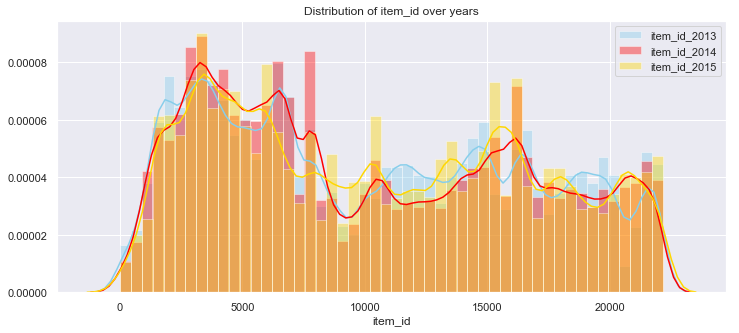

In [70]:
plt.figure(figsize=(12,5))
plt.title("Distribution of item_id over years")

item_id_2013 = sales[(sales['date_block_num']<13)]['item_id']
item_id_2014 = sales[(sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_id']
item_id_2015 = sales[(24<sales['date_block_num'])]['item_id']

sns.distplot( item_id_2013 , color="skyblue", label="item_id_2013")
sns.distplot( item_id_2014 , color="red", label="item_id_2014")
sns.distplot( item_id_2015 , color="gold", label="item_id_2015")
plt.legend()

## 2.6 item_cnt_month over years

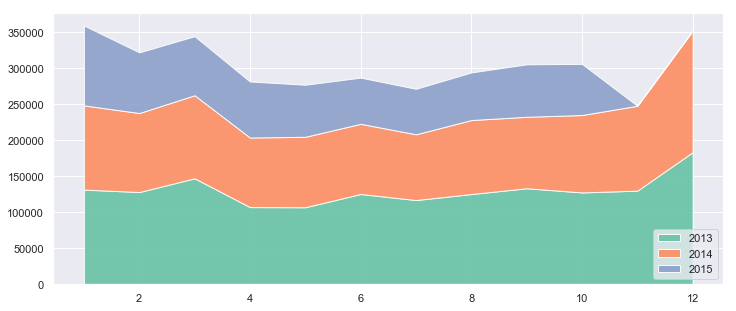

In [67]:
plt.figure(figsize=(12,5))
x = range(1,13)
ys = sales.groupby(['date_block_num'],as_index=False)['item_cnt_day'].agg('sum')['item_cnt_day']
y = [list(ys[:12]), list(ys[12:24]), list(ys[24:])+[0,0]]
pal = sns.color_palette("Set2")
plt.stackplot(x,y, labels=['2013','2014','2015'], colors=pal, alpha=0.9 )
plt.legend(loc='lower right')

## 2.7 Relation between item_price and item_id

<Figure size 864x864 with 0 Axes>

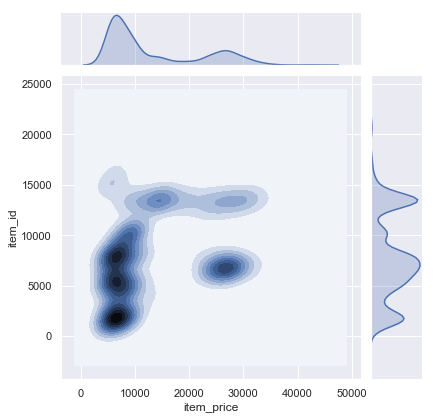

In [76]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (24<sales['date_block_num'])]['item_price'], y=sales[(sales['item_price']>5000) & (24<sales['date_block_num'])]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

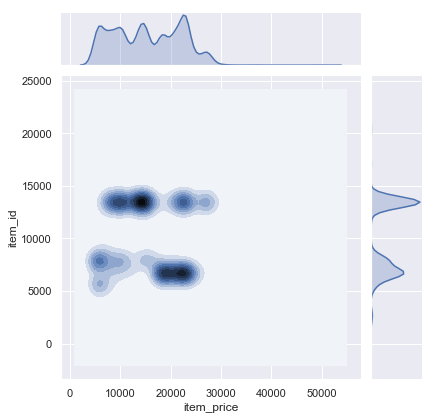

In [77]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_price'], y=sales[(sales['item_price']>5000) & (sales['date_block_num']<25) & (sales['date_block_num']>12)]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

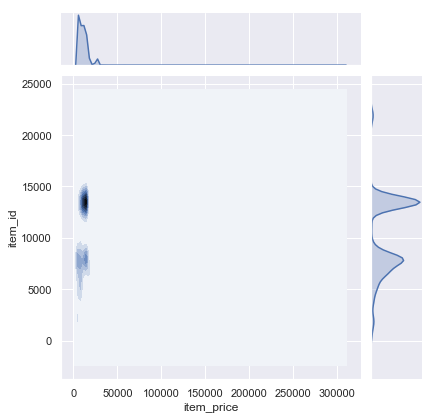

In [78]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']>5000) & (sales['date_block_num']<13)]['item_price'], y=sales[(sales['item_price']>5000) & (sales['date_block_num']<13)]['item_id'], kind='kde')

<Figure size 864x864 with 0 Axes>

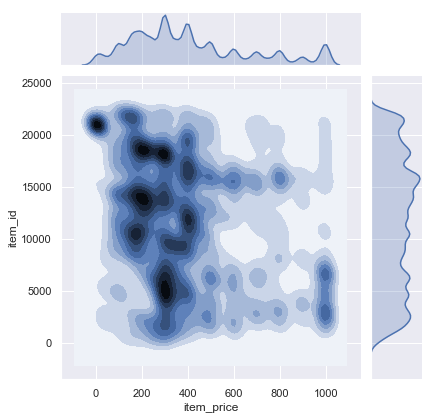

In [80]:
plt.figure(figsize=(12,12))
sns.jointplot(x=sales[(sales['item_price']<1000) & (24<sales['date_block_num'])]['item_price'], y=sales[(sales['item_price']<1000) & (24<sales['date_block_num'])]['item_id'], kind='kde')

# 3. Feature Engineering

In [21]:
sales = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv.gz')
submission = pd.read_csv('sample_submission.csv.gz')

In [6]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [37]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [18]:
#Make Monthly
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year
sales = sales.drop(['date'], axis=1)
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.00,1.0,1,2013
1,0,25,2552,899.00,1.0,1,2013
2,0,25,2552,899.00,-1.0,1,2013
3,0,25,2554,1709.05,1.0,1,2013
4,0,25,2555,1099.00,1.0,1,2013


In [19]:
sales = sales.groupby([c for c in sales.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
sales = sales.rename(columns={'item_cnt_day':'item_cnt_month'})
#Monthly Mean
shop_item_monthly_mean = sales[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
#Add Mean Feature
sales = pd.merge(sales, shop_item_monthly_mean, how='left', on=['shop_id','item_id'])
sales.head()

,date_block_num,shop_id,item_id,item_price,month,year,item_cnt_month,item_cnt_month_mean
0,0,0,32,221.0,1,2013,6.0,8.000000
1,0,0,33,347.0,1,2013,3.0,3.000000
2,0,0,35,247.0,1,2013,1.0,7.500000
3,0,0,43,221.0,1,2013,1.0,1.000000
4,0,0,51,127.0,1,2013,1.0,1.666667


In [40]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = sales['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [42]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = sales.loc[dates <  last_block].drop(['item_cnt_month'], axis=1)
X_test =  sales.loc[dates == last_block].drop(['item_cnt_month'], axis=1)

y_train = sales.loc[dates <  last_block, 'item_cnt_month'].values
y_test =  sales.loc[dates == last_block, 'item_cnt_month'].values

In [48]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**2, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_leaves':256 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 1000)
pred_lgb = model.predict(X_train[-1000:])

print('Test R-squared for LightGBM is %f' % r2_score(y_train[-1000:], pred_lgb))

Test R-squared for LightGBM is 0.460243


In [54]:
from sklearn import metrics
pred_lgb = model.predict(X_train[-10000:])
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train[-10000:].clip(0.,20.), pred_lgb.clip(0.,20.))))

RMSE: 1.2479076489


## 3.1 Get a feature matrix

In [22]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,20)
#gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb = sales.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb['item_cnt_month'] = gb['item_cnt_month'].clip(0,20).astype(np.int)

# Fix column names
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
#gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
gb = sales.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'target_shop'})
gb['target_shop'] = gb['target_shop'].clip(0,20).astype(np.int)

all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
#gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
#gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
gb = sales.groupby(['item_id', 'date_block_num'])['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'target_item'})
gb['target_item'] = gb['target_item'].clip(0,20).astype(np.int)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


In [23]:
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item
139255,0,19,0,0.0,20,1
141495,0,27,0,0.0,20,7
144968,0,28,0,0.0,20,8
142661,0,29,0,0.0,20,5
138947,0,32,0,6.0,20,20


In [24]:
l_cat = list(item_cats.item_category_name)

for ind in range(0,1):

    l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

    l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'

In [25]:
all_data = all_data.merge(items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')

test = test.merge(items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')

In [26]:
from sklearn import preprocessing

lb = preprocessing.LabelEncoder()

item_cats['item_cat_id_fix'] = lb.fit_transform(l_cat)



all_data = all_data.merge(item_cats[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

test = test.merge(item_cats[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')



all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix
0,0,19,0,0.0,20,1,40,11
1,0,27,0,0.0,20,7,19,7
2,0,28,0,0.0,20,8,30,3
3,0,29,0,0.0,20,5,23,7
4,0,32,0,6.0,20,20,40,11


In [6]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

## 3.2 Lags features

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 6, 12] months ago.

In [7]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 6, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

A Jupyter Widget

In [18]:
all_data[(all_data['shop_id'] == 28) & (all_data['item_id'] == 10994)& (all_data['date_block_num']== 12)]

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
106344,28,10994,12,1.0,6949.0,15.0,0.0,44.0,8499.0,0.0,4.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37


## 3.3 Mean encodings features

In [27]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,item_cat_id_fix
0,0,19,0,0.0,20,1,40,11
1,0,27,0,0.0,20,7,19,7
2,0,28,0,0.0,20,8,30,3
3,0,29,0,0.0,20,5,23,7
4,0,32,0,6.0,20,20,40,11


### 3.3.1 KFold scheme regularization

In [14]:
from sklearn.model_selection import KFold

mean_encoded_col = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix']
global_mean =  train['item_cnt_month'].mean()
for col in tqdm(mean_encoded_col):
    kf = KFold(n_splits=5,shuffle=False)
    all_data[col+'_enc_kf'] = np.nan

    for train_index , test_index in kf.split(all_data['item_cnt_month'].values):
        x_tr, x_val = all_data.iloc[train_index], all_data.iloc[test_index]
        means = x_val[col].map(x_tr.groupby(col).target.mean())
        all_data[col+'_enc_kf'].iloc[test_index] = means
    all_data[col+'_enc_kf'].fillna(0.3343, inplace=True) 

C:\Users\whisp\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
# Fill NaNs
all_data['item_target_enc_kf'].fillna(0.3343, inplace=True) 
# YOUR CODE GOES HERE
encoded_feature = all_data['item_target_enc_kf']


# You will need to compute correlation like that
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.382118332143


### 3.3.2 Leave-one-out scheme regularization

In [16]:
all_data['item_target_enc_loo'] = all_data.groupby('item_id')['target'].transform('sum') - all_data['target']
all_data['item_target_enc_loo'] /= (all_data.groupby('item_id')['target'].transform('count')-1)
# Fill NaNs
all_data['item_target_enc_loo'].fillna(0.3343, inplace=True) 

encoded_feature = all_data['item_target_enc_loo']
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.461472414727


### 3.3.3 Smoothing regularization

In [17]:
alpha = 100
mean_target = all_data.groupby('item_id')['target'].transform('mean')
nrow = all_data.groupby('item_id')['target'].transform('count') 
all_data['item_target_enc_smoo'] = (mean_target*nrow + 0.3343*alpha)/(nrow+alpha)

# Fill NaNs
all_data['item_target_enc_smoo'].fillna(0.3343, inplace=True) 

encoded_feature = all_data['item_target_enc_smoo']
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.463568418138


### 3.3.4 Expanding mean scheme regularization

In [18]:
cumsum = all_data.groupby('item_id')['target'].cumsum()-all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc_expan'] = cumsum/cumcnt

# Fill NaNs
all_data['item_target_enc_expan'].fillna(0.3343, inplace=True) 

encoded_feature = all_data['item_target_enc_expan']
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.475370561658


# 4. Train/test split
Let's artificially split the data into train and test. We will treat last month data as the test set.

In [21]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [22]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [38]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,item_target_enc_kf,item_target_enc_loo,item_target_enc_smoo,item_target_enc_expan
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.074755,0.113682,0.137379,0.3343
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,0.098630,0.123212,0.146960,0.3343
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,1.431898,1.663777,1.557884,0.3343
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.213953,0.245665,0.255865,0.3343
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,1.0,9.0,7225.0,0.0,0.0,0.0,57,0.062338,0.065410,0.093151,0.3343


In [23]:
col_train = [ 'shop_id','item_id','target_lag_1','target_item_lag_1','target_shop_lag_1',
             'target_lag_2','target_item_lag_2','target_shop_lag_2','target_lag_3',
             'target_item_lag_3','target_shop_lag_3','target_lag_4','target_item_lag_4',
             'target_shop_lag_4','target_lag_5','target_item_lag_5','target_shop_lag_5',
             'target_lag_12','target_item_lag_12','target_shop_lag_12','item_category_id']
x = X_train[col_train]
xt = X_test[col_train]

In [36]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,1.0,9.0,7225.0,0.0,0.0,0.0,57


In [32]:
X_test.shape

(238172, 24)

In [33]:
x[-238172*10:]

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
3805202,15,21844,0.0,0.0,0.0,0.0,1.0,2017.0,0.0,1.0,2033.0,0.0,3.0,2009.0,0.0,0.0,0.0,0.0,5.0,4186.0,41
3805203,15,21283,0.0,0.0,0.0,0.0,4.0,2017.0,0.0,4.0,2033.0,0.0,5.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3805204,15,21266,0.0,0.0,0.0,0.0,5.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3805205,15,21262,0.0,0.0,0.0,0.0,7.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3805206,15,21260,0.0,0.0,0.0,0.0,4.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3805207,15,21081,0.0,3.0,2158.0,0.0,19.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3805208,15,21359,0.0,3.0,2158.0,0.0,3.0,2017.0,0.0,6.0,2033.0,0.0,9.0,2009.0,0.0,11.0,1650.0,1.0,12.0,4186.0,37
3805209,15,19689,0.0,2.0,2158.0,0.0,1.0,2017.0,0.0,2.0,2033.0,0.0,2.0,2009.0,0.0,6.0,1650.0,0.0,17.0,4186.0,41
3805210,15,17439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2033.0,0.0,1.0,2009.0,0.0,1.0,1650.0,0.0,10.0,4186.0,37
3805211,15,19254,0.0,2.0,2158.0,1.0,8.0,2017.0,1.0,9.0,2033.0,0.0,15.0,2009.0,0.0,11.0,1650.0,0.0,6.0,4186.0,28


In [43]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(x, label=y_train), 100)
pred_lgb = model.predict(xt)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.281754


In [35]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**2, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_leaves':256
              }

model = lgb.train(lgb_params, lgb.Dataset(x[-238172*10:], label=y_train[-238172*10:]), 500)
pred_lgb = model.predict(xt)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.352366


In [36]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**4, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_leaves':128
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.322770


In [37]:
pred_lgb = model.predict(X_train)

print('Test R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Test R-squared for LightGBM is 0.729467


In [95]:
from catboost import CatBoostRegressor
from sklearn import metrics

In [96]:
#CatBoost
cb_model = CatBoostRegressor(iterations=100, learning_rate=0.2, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.004505352578051


In [97]:
#CatBoost
cb_model = CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.004505352578051


In [98]:
#CatBoost
cb_model = CatBoostRegressor(iterations=5000, learning_rate=0.05, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20) 
cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test.clip(0.,20.), cb_model.predict(X_test).clip(0.,20.))))

RMSE: 1.0027329909297533


## 4.1 First level models

# To DO: 
- KNN features
- validation
- stacking 

In [91]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,item_target_enc_kf,item_target_enc_loo,item_target_enc_smoo,item_target_enc_expan
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.074755,0.113682,0.137379,0.3343
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,0.098630,0.123212,0.146960,0.3343
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,1.431898,1.663776,1.557884,0.3343
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.213953,0.245665,0.255865,0.3343
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,1.0,9.0,7225.0,0.0,0.0,0.0,57,0.062338,0.065410,0.093151,0.3343
5,54,10292,12,9.0,8198.0,93.0,8.0,156.0,10055.0,16.0,203.0,7978.0,15.0,279.0,6676.0,38.0,445.0,7827.0,11.0,140.0,7792.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.781141,0.835260,0.798446,0.3343
6,54,10109,12,2.0,8198.0,17.0,1.0,19.0,10055.0,0.0,15.0,7978.0,0.0,17.0,6676.0,0.0,18.0,7827.0,1.0,28.0,7792.0,0.0,20.0,7225.0,0.0,0.0,0.0,40,0.087774,0.115196,0.141145,0.3343
7,54,10107,12,1.0,8198.0,26.0,2.0,23.0,10055.0,6.0,39.0,7978.0,2.0,48.0,6676.0,6.0,67.0,7827.0,2.0,75.0,7792.0,1.0,53.0,7225.0,3.0,32.0,9386.0,37,0.097561,0.193548,0.215116,0.3343
8,54,10121,12,1.0,8198.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9386.0,37,0.028689,0.023881,0.097317,0.3343
9,54,10143,12,1.0,8198.0,12.0,1.0,18.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.108140,0.131021,0.149631,0.3343
